In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ashishjangra27/gender-recognition-200k-images-celeba

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 1.30G/1.32G [00:09<00:00, 189MB/s]
100% 1.32G/1.32G [00:09<00:00, 143MB/s]


In [ ]:
!unzip "/content/gender-recognition-200k-images-celeba.zip"

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.desc = nn.Sequential(
        self._block(3, 32, 3, 2),
        self._block(32, 64, 3, 2),
        self._block(64, 128, 4, 2),
    )
    self.linear = nn.Sequential(
        nn.Linear(128*2*2, 1),
        nn.Sigmoid()
    )

  def _block(self, in_features, out_features, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel_size, stride),
        nn.LeakyReLU(0.1),
    )

  def forward(self, x):
    x = self.desc(x)
    x = x.view(-1, 128*2*2)
    x = self.linear(x)
    return x


class Generator(nn.Module):
  def __init__(self, z_dim, img_w, img_h):
    super().__init__()
    self.linear_1 = nn.Linear(z_dim, 2*2*128)
    self.gen = nn.Sequential(
      self._block(128, 64, 4, 4),
      self._block(64, 32, 2, 2),
      self._block(32, 16, 2, 2),
      nn.ConvTranspose2d(16, 3, 2, 2),
      nn.Tanh()
    )

  def _block(self, in_features, out_features, kernel_size, stride):
    return nn.Sequential(
        nn.ConvTranspose2d(in_features, out_features, kernel_size, stride),
        nn.LeakyReLU(0.1),
        nn.BatchNorm2d(out_features)
    )

  def forward(self, x):
    x = self.linear_1(x)
    x = x.view(-1, 128, 2, 2)
    x = self.gen(x)
    return x

device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
batch_size = 32
num_epochs = 500

disc = Discriminator().to(device)
gen = Generator(z_dim, 64, 64).to(device)

fixed_noise = torch.randn((batch_size, z_dim)).to(device)
tra = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

# dataset = datasets.CIFAR10(
#     root="dataset/",
#     transform=tra,
#     download=True
# )

dataset = datasets.ImageFolder(
    root="Dataset/Train/",
    transform=tra
)

dataset = Subset(dataset, list(range(10000)))
# x_test, _ = next(iter(dataset))
# print(x_test.shape)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
loss_fn = nn.BCELoss()

gen.train()
disc.train()

for epoch in range(num_epochs):
  for batch_idx, (real, _) in enumerate(loader):
    real = real.to(device)
    batch_size = real.shape[0]

    ## train the discriminator
    noise = torch.randn((batch_size, z_dim)).to(device)
    fake = gen(noise)

    disc_real = disc(real).view(-1)
    lossD_real = loss_fn(disc_real, torch.ones_like(disc_real))

    disc_fake = disc(fake).view(-1)
    lossD_fake = loss_fn(disc_fake, torch.zeros_like(disc_fake))
    lossD = (lossD_real + lossD_fake)/2
    disc.zero_grad()
    lossD.backward(retain_graph=True)
    opt_disc.step()

    ## train the generator
    output = disc(fake).view(-1)
    lossG = loss_fn(output, torch.ones_like(output))
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

    print(f"\repoch {epoch+1}/{num_epochs} batch: {batch_idx+1}/{len(loader)} --- d_loss: {lossD.item()} --- g_loss: {lossG.item()}", end="")

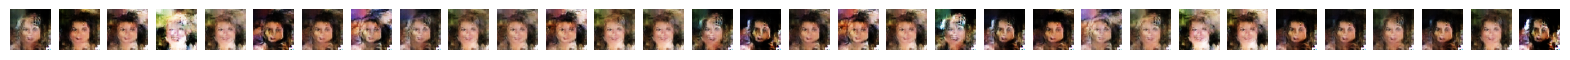

In [ ]:
gen.eval()
imgs = gen(fixed_noise)

imgs = (imgs - imgs.min())/(imgs.max() - imgs.min())
fig = plt.figure(figsize=(20, 10))
rows = 1
cols = imgs.shape[0]

for i, img in enumerate(imgs):
  fig.add_subplot(rows, cols, i + 1)
  # img = img.view(3, 32, 32)
  img = transforms.ToPILImage()(img)
  img = np.array(img)
  plt.axis("off")
  plt.imshow(img, cmap="gray")


In [ ]:
torch.save(gen.state_dict(), "gen.ptd")